In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pmdarima import auto_arima

In [4]:
df = pd.read_csv('historical_weather.csv')
df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [5]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [6]:
# Fill missing avg_temp_c values with mean
df['avg_temp_c'].fillna(df['avg_temp_c'].mean(), inplace=True)
df['avg_wind_speed_kmh'].fillna(df['avg_wind_speed_kmh'].mean(), inplace=True)

# Fill missing min_temp_c values with median
df['min_temp_c'].fillna(df['min_temp_c'].median(), inplace=True)
df['max_temp_c'].fillna(df['max_temp_c'].median(), inplace=True)

# guessing the missing values are forwarded
df['min_temp_c'].fillna(method='ffill', inplace=True)
df['max_temp_c'].fillna(method='ffill', inplace=True)
df['avg_wind_dir_deg'].fillna(method='ffill', inplace=True)

# guessing the missing values are 0
df['precipitation_mm'].fillna(0, inplace=True)
df['snow_depth_mm'].fillna(0, inplace=True)

df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,0.0,0.0,155.0,5.8
3,C001,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,0.0,0.0,291.0,5.0


## ARIMA

In [147]:
df_arima = df.copy()
df_arima.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,0.0,0.0,155.0,5.8
3,C001,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,0.0,0.0,291.0,5.0


In [148]:
df_arima.sort_values(by='date', inplace=True)
df_arima.set_index('date', inplace=True)

In [149]:
df_arima = df_arima['avg_temp_c']
train = df_arima[:'2017-12-31']
test = df_arima['2018-01-01':]

In [150]:
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             avg_temp_c   No. Observations:               145846
Model:                 ARIMA(2, 1, 0)   Log Likelihood             -550596.385
Date:                Sun, 23 Jun 2024   AIC                        1101198.771
Time:                        01:39:09   BIC                        1101228.442
Sample:                             0   HQIC                       1101207.625
                             - 145846                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6679      0.002   -291.208      0.000      -0.672      -0.663
ar.L2         -0.3314      0.002   -144.392      0.000      -0.336      -0.327
sigma2       111.3348      0.403    275.965      0.0

RMSE (ARIMA): 11.757114916394947


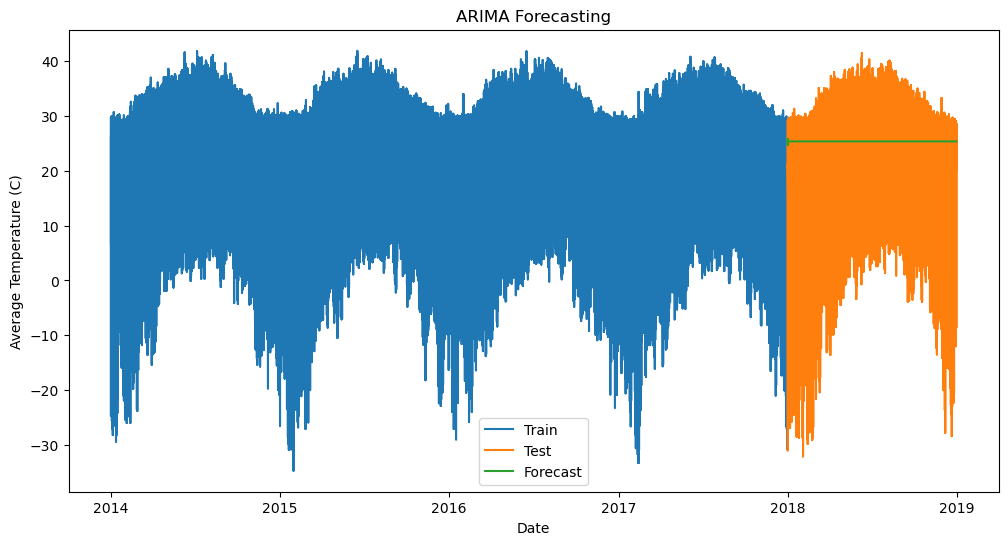

In [151]:
fc = model_fit.forecast(len(test))
print(f'RMSE (ARIMA): {np.sqrt(mean_squared_error(test, fc))}')

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, fc, label='Forecast')
plt.legend()
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Average Temperature (C)')
plt.show()

In [ ]:
auto_model = auto_arima(train, start_p=1, start_q=1,
                        max_p=3, max_q=3, m=12,  # Seasonal parameters if any
                        start_P=0, seasonal=True,
                        d=None, D=1, trace=True,
                        error_action='ignore',  # don't want to know if an order does not work
                        suppress_warnings=True,  # don't want convergence warnings
                        stepwise=True)  # set to stepwise

# Print the summary of the best model found by auto_arima
print(auto_model.summary())

# Forecast with the best model
forecast = auto_model.predict(n_periods=len(test))

# Calculate MSE
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error (ARIMA): {mse}')

## LSTM

In [13]:
df_lstm = df.copy()
df_lstm.index = df_lstm['date']

In [63]:
df_lstm.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
date,,,,,,,,,
2014-01-01,C001,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2
2014-01-02,C001,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0
2014-01-03,C001,2014-01-03,7.6,1.9,14.0,0.0,0.0,155.0,5.8
2014-01-04,C001,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3
2014-01-05,C001,2014-01-05,8.6,0.5,16.9,0.0,0.0,291.0,5.0


<Axes: xlabel='date'>

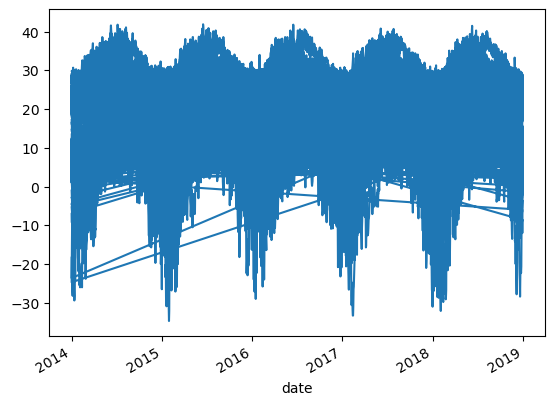

In [67]:
temps = df_lstm['avg_temp_c']
temps.plot()

In [66]:
def X_y_matrix(data:pd.DataFrame, window_size):
    df_as_np = data.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y) 

In [68]:
X, y = X_y_matrix(temps, 5)
X.shape, y.shape

((182333, 5, 1), (182333,))

In [70]:
X_train, y_train = X[:170000], y[:170000]
X_val, y_val = X[170000:179000], y[170000:179000]
X_test, y_test = X[179000:], y[179000:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((170000, 5, 1), (170000,), (9000, 5, 1), (9000,), (3333, 5, 1), (3333,))

In [71]:
import tensorflow
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [77]:
from tensorflow.keras.models import load_model

In [72]:
tf_model = Sequential()
tf_model.add(InputLayer((5, 1)))
tf_model.add(LSTM(64))
tf_model.add(Dense(8, 'relu'))
tf_model.add(Dense(1, 'linear'))

tf_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
cp = ModelCheckpoint('tf_model/model_checkpoint.keras', save_best_only=True)
tf_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [76]:
tf_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
5313/5313 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 3.4726 - root_mean_squared_error: 1.8634 - val_loss: 3.4949 - val_root_mean_squared_error: 1.8695
Epoch 2/20
5313/5313 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 3.5062 - root_mean_squared_error: 1.8724 - val_loss: 3.5666 - val_root_mean_squared_error: 1.8885
Epoch 3/20
5313/5313 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 3.4400 - root_mean_squared_error: 1.8546 - val_loss: 3.4949 - val_root_mean_squared_error: 1.8695
Epoch 4/20
5313/5313 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 3.4748 - root_mean_squared_error: 1.8639 - val_loss: 3.5086 - val_root_mean_squared_error: 1.8731
Epoch 5/20
5313/5313 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 3.4615 - root_mean_squared_error: 1.8605 - val_loss: 3.5011 - val_root_mean_squared_error: 1.8711
Epoch 6/20
5313/5313 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 3.4856 - root_mean_squared_error: 1.8668 - val_loss: 3.5093 - val_root_mean_squared_error: 1.8733
Epoch 7/20
5313/5313 ━━━━━━━━━━━━━━━━━━━

In [78]:
tf_best = load_model('tf_model/model_checkpoint.keras')

In [79]:
predictions = tf_best.predict(X_test).flatten()
pred_df = pd.DataFrame(data={'Test Pred':predictions, 'Actual':y_test})
pred_df

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Test Pred,Actual
0,26.680172,26.2
1,26.244719,27.8
2,27.468500,26.6
3,26.312311,27.3
4,27.216141,27.2
...,...,...
3328,21.731554,22.0
3329,21.651289,21.9
3330,21.840940,22.4
3331,22.430359,21.6


In [81]:
mean_squared_error(pred_df['Actual'], pred_df['Test Pred'])

2.7365542807061702

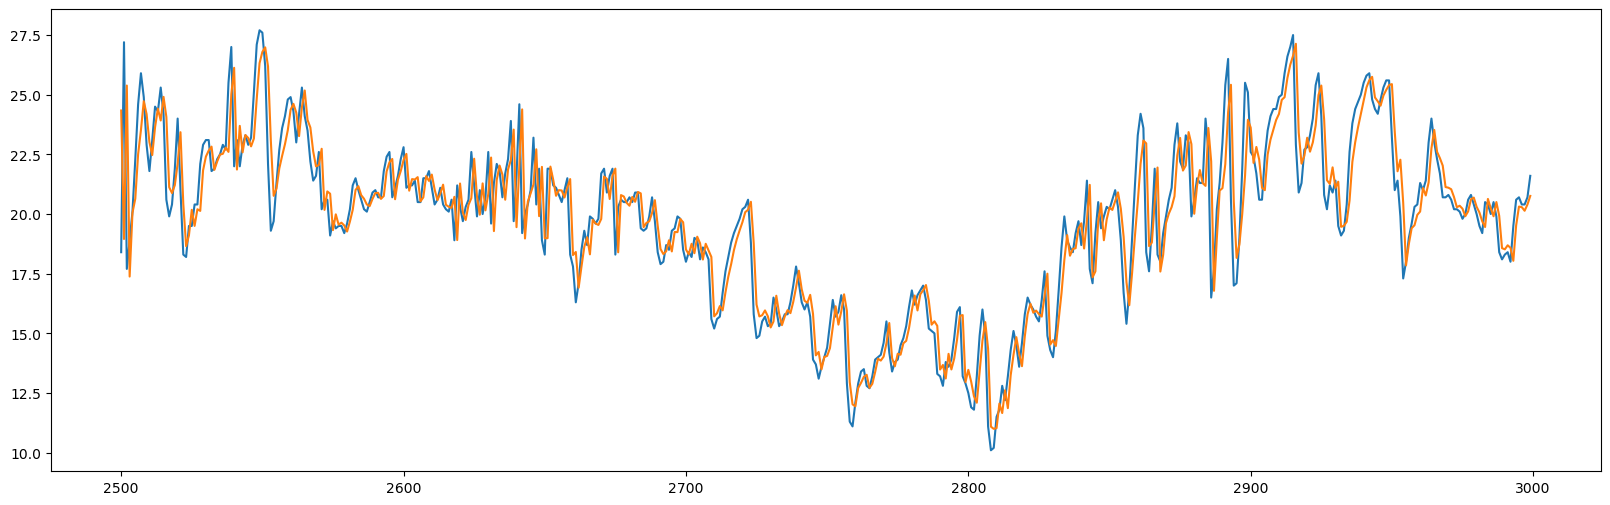

In [91]:
plt.figure(figsize=[20, 6])
plt.plot(pred_df['Actual'][2500:3000])
plt.plot(pred_df['Test Pred'][2500:3000])

In [92]:
sub_key = pd.read_csv('submission_key.csv')
sub_key.head()

,submission_ID,city_id,date
0,1,C001,2019-01-01
1,2,C001,2019-01-02
2,3,C001,2019-01-03
3,4,C001,2019-01-04
4,5,C001,2019-01-05


## LSTM 2

In [104]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
df_lstm2 = df_lstm[['city_id', 'avg_temp_c']]
df_lstm2.head()

,city_id,avg_temp_c
date,,
2014-01-01,C001,6.6
2014-01-02,C001,9.3
2014-01-03,C001,7.6
2014-01-04,C001,7.6
2014-01-05,C001,8.6


In [15]:
response_map = {}
cities = df_lstm2['city_id'].unique() 
for i in range(len(cities)):
    response_map[cities[i]] = i
    
print(response_map)

{'C001': 0, 'C002': 1, 'C003': 2, 'C004': 3, 'C005': 4, 'C007': 5, 'C008': 6, 'C009': 7, 'C010': 8, 'C011': 9, 'C012': 10, 'C013': 11, 'C014': 12, 'C015': 13, 'C016': 14, 'C017': 15, 'C018': 16, 'C020': 17, 'C022': 18, 'C023': 19, 'C024': 20, 'C025': 21, 'C027': 22, 'C028': 23, 'C029': 24, 'C030': 25, 'C031': 26, 'C033': 27, 'C034': 28, 'C035': 29, 'C036': 30, 'C037': 31, 'C038': 32, 'C039': 33, 'C040': 34, 'C042': 35, 'C043': 36, 'C044': 37, 'C045': 38, 'C046': 39, 'C047': 40, 'C048': 41, 'C049': 42, 'C051': 43, 'C053': 44, 'C054': 45, 'C055': 46, 'C056': 47, 'C057': 48, 'C058': 49, 'C059': 50, 'C061': 51, 'C062': 52, 'C064': 53, 'C065': 54, 'C066': 55, 'C067': 56, 'C068': 57, 'C069': 58, 'C070': 59, 'C071': 60, 'C072': 61, 'C073': 62, 'C074': 63, 'C076': 64, 'C077': 65, 'C078': 66, 'C079': 67, 'C081': 68, 'C082': 69, 'C083': 70, 'C084': 71, 'C085': 72, 'C086': 73, 'C087': 74, 'C088': 75, 'C089': 76, 'C090': 77, 'C091': 78, 'C092': 79, 'C093': 80, 'C094': 81, 'C095': 82, 'C096': 83, '

In [108]:
df_lstm2['city_id'] = df_lstm2['city_id'].map(response_map)

In [109]:
df_lstm2.reset_index(inplace=True)
df_lstm2.head()

,date,city_id,avg_temp_c
0,2014-01-01,0,6.6
1,2014-01-02,0,9.3
2,2014-01-03,0,7.6
3,2014-01-04,0,7.6
4,2014-01-05,0,8.6


In [110]:
df_lstm2['date'] = pd.to_datetime(df_lstm2['date']).map(pd.Timestamp.toordinal)
df_lstm2.head()

,date,city_id,avg_temp_c
0,735234,0,6.6
1,735235,0,9.3
2,735236,0,7.6
3,735237,0,7.6
4,735238,0,8.6


In [111]:
scaler = MinMaxScaler()
df_lstm2[['date', 'city_id']] = scaler.fit_transform(df_lstm2[['date', 'city_id']])
df_lstm2.head()

,date,city_id,avg_temp_c
0,0.000000,0.0,6.6
1,0.000548,0.0,9.3
2,0.001096,0.0,7.6
3,0.001644,0.0,7.6
4,0.002192,0.0,8.6


In [112]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].drop(columns='avg_temp_c').values
        label = data.iloc[i+seq_length]['avg_temp_c']
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

In [113]:
# Define sequence length
seq_length = 10  # for example, 30 days

# Get sequences and labels
X, y = create_sequences(df_lstm2, seq_length)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [117]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

cp_1 = ModelCheckpoint('tf_model/model_checkpoint_1.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 10, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[cp_1])

Epoch 1/20
3647/3647 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 101.4520 - root_mean_squared_error: 10.0723 - val_loss: 90.2813 - val_root_mean_squared_error: 9.5016
Epoch 2/20
3647/3647 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 101.0721 - root_mean_squared_error: 10.0534 - val_loss: 89.4088 - val_root_mean_squared_error: 9.4556
Epoch 3/20
3647/3647 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 101.5299 - root_mean_squared_error: 10.0761 - val_loss: 90.6938 - val_root_mean_squared_error: 9.5233
Epoch 4/20
3647/3647 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 101.6794 - root_mean_squared_error: 10.0835 - val_loss: 89.8031 - val_root_mean_squared_error: 9.4765
Epoch 5/20
3647/3647 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 101.4253 - root_mean_squared_error: 10.0709 - val_loss: 90.0100 - val_root_mean_squared_error: 9.4874
Epoch 6/20
3647/3647 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 102.2087 - root_mean_squared_error: 10.1093 - val_loss: 90.1324 - val_root_mean_squared_error: 9.4938
Epoch 7/20

In [122]:
best_model_2 = load_model('tf_model/model_checkpoint_1.keras')

# Inverse transform the predictions
predictions = best_model_2.predict(X_test)
pred_df_2 = pd.DataFrame(data={'Test Pred':predictions, 'Actual':y_test})
pred_df_2

1140/1140 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Temperature')
plt.plot(predictions, color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Hybrid

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

In [23]:
df_hyb = df.copy()
df_hyb.set_index('date', inplace=True)
df_hyb.head()

,city_id,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
date,,,,,,,,
2014-01-01,C001,6.6,-1.4,11.6,0.0,0.0,168.0,6.2
2014-01-02,C001,9.3,6.3,13.3,0.0,0.0,155.0,10.0
2014-01-03,C001,7.6,1.9,14.0,0.0,0.0,155.0,5.8
2014-01-04,C001,7.6,3.9,13.3,0.0,0.0,291.0,11.3
2014-01-05,C001,8.6,0.5,16.9,0.0,0.0,291.0,5.0


In [24]:
df_hyb.sort_index(inplace=True)

In [25]:
df_hyb = df_hyb[['city_id', 'avg_temp_c']]
df_hyb.head()

,city_id,avg_temp_c
date,,
2014-01-01,C001,6.6
2014-01-01,C083,28.5
2014-01-01,C082,26.1
2014-01-01,C081,19.6
2014-01-01,C079,4.3


In [26]:
df_hyb['city_id'] = df_hyb['city_id'].map(response_map)
df_hyb.head()

,city_id,avg_temp_c
date,,
2014-01-01,0,6.6
2014-01-01,70,28.5
2014-01-01,69,26.1
2014-01-01,68,19.6
2014-01-01,67,4.3


In [27]:
df_hyb['year'] = df_hyb.index.year
df_hyb['month'] = df_hyb.index.month
df_hyb['day'] = df_hyb.index.day
df_hyb['dayofweek'] = df_hyb.index.dayofweek
df_hyb['lag1'] = df_hyb['avg_temp_c'].shift(1)
df_hyb['rolling_mean_7'] = df_hyb['avg_temp_c'].rolling(window=7).mean()
df_hyb['rolling_std_7'] = df_hyb['avg_temp_c'].rolling(window=7).std()

df_hyb.head()

,city_id,avg_temp_c,year,month,day,dayofweek,lag1,rolling_mean_7,rolling_std_7
date,,,,,,,,,
2014-01-01,0,6.6,2014,1,1,2,NaN,NaN,NaN
2014-01-01,70,28.5,2014,1,1,2,6.6,NaN,NaN
2014-01-01,69,26.1,2014,1,1,2,28.5,NaN,NaN
2014-01-01,68,19.6,2014,1,1,2,26.1,NaN,NaN
2014-01-01,67,4.3,2014,1,1,2,19.6,NaN,NaN


In [28]:
df_hyb.dropna(inplace=True)

In [60]:
train = df_hyb[df_hyb.index.year < 2018]
test = df_hyb[df_hyb.index.year >= 2018]

In [43]:
sarima_model = SARIMAX(train['avg_temp_c'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88806D+00    |proj g|=  7.66211D-02


 This problem is unconstrained.



At iterate    5    f=  3.70112D+00    |proj g|=  4.54656D-02

At iterate   10    f=  3.63758D+00    |proj g|=  8.35235D-03

At iterate   15    f=  3.63525D+00    |proj g|=  3.13333D-02

At iterate   20    f=  3.62966D+00    |proj g|=  6.55168D-03
  ys=-4.037E-04  -gs= 4.875E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  3.62945D+00    |proj g|=  6.97768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     62      2     1     0   1.160D-03   3.629D+00
  F =   3.6294524590381050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [68]:
sarima_preds = sarima_fit.predict(start=test.index.min(), end=test.index.max())

In [63]:
features = ['year', 'month', 'day', 'dayofweek', 'lag1', 'rolling_mean_7', 'rolling_std_7']
X_train = train[features]
y_train = train['avg_temp_c']
X_test = test[features]
y_test = test['avg_temp_c']

In [65]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.0001)
xgboost_model.fit(X_train, y_train)
xgboost_preds = xgboost_model.predict(X_test)

In [74]:
sarima_preds = sarima_preds.drop(sarima_preds.index('2018-12-31'))

TypeError: 'DatetimeIndex' object is not callable

In [73]:
xgboost_preds

array([19.286474, 19.71239 , 19.476723, ..., 18.928514, 18.657269,
       19.13235 ], dtype=float32)

In [69]:
combined_preds = (0.5 * sarima_preds + 0.5 * xgboost_preds)

ValueError: operands could not be broadcast together with shapes (36393,) (36492,) 

In [67]:
rmse = np.sqrt(mean_squared_error(y_test, xgboost_preds))
print(f'Hybrid Model RMSE: {rmse}')

Hybrid Model RMSE: 9.65721272296941


## Test

In [188]:
test_df = df.copy()
test_df['city_id'] = test_df['city_id'].map(response_map)
test_df = test_df[['city_id', 'date', 'avg_temp_c']]
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day

test_df.head()

,city_id,date,avg_temp_c,year,month,day
0,0,2014-01-01,6.6,2014,1,1
1,0,2014-01-02,9.3,2014,1,2
2,0,2014-01-03,7.6,2014,1,3
3,0,2014-01-04,7.6,2014,1,4
4,0,2014-01-05,8.6,2014,1,5


In [189]:
test_df.drop(columns=['date'], inplace=True)
test_df

,city_id,avg_temp_c,year,month,day
0,0,6.6,2014,1,1
1,0,9.3,2014,1,2
2,0,7.6,2014,1,3
3,0,7.6,2014,1,4
4,0,8.6,2014,1,5
...,...,...,...,...,...
182333,99,22.0,2018,12,27
182334,99,21.9,2018,12,28
182335,99,22.4,2018,12,29
182336,99,21.6,2018,12,30


In [190]:
y = test_df['avg_temp_c']
test_df.drop(columns=['avg_temp_c'], inplace=True)

In [191]:
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler(copy=True)

# test_df_scaled = scaler.fit_transform(test_df)
# test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)
# test_df_scaled.head()

test_df_scaled = test_df.copy()

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(test_df_scaled, y, test_size=0.2, random_state=None)

In [193]:
X_test

,city_id,year,month,day
122624,67,2015,4,4
37970,20,2018,2,22
99930,54,2018,1,26
154012,84,2016,4,23
6166,3,2015,12,16
...,...,...,...,...
115363,63,2015,5,16
159929,87,2017,7,15
139056,76,2015,4,18
33750,18,2016,8,3


In [169]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.0001)
xgboost_model.fit(X_train, y_train)
xgboost_preds = xgboost_model.predict(X_test)
print(f"{mean_squared_error(y_true=y_test, y_pred=xgboost_preds)}  {np.sqrt(mean_squared_error(y_true=y_test, y_pred=xgboost_preds))}")

66.63096736178312  8.1627793895084


In [170]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.0001)
xgboost_model.fit(test_df_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [171]:
df_key = pd.read_csv('submission_key.csv')

df_key['date'] = pd.to_datetime(df_key['date'])
df_key_copy = df_key.copy()

df_key_copy['year'] = df_key_copy['date'].dt.year
df_key_copy['month'] = df_key_copy['date'].dt.month
df_key_copy['day'] = df_key_copy['date'].dt.day


df_key_copy['city_id'] = df_key_copy['city_id'].map(response_map)

df_key_copy.drop(columns=['submission_ID', 'date'], inplace=True)
df_key_copy.head()

,city_id,year,month,day
0,0,2019,1,1
1,0,2019,1,2
2,0,2019,1,3
3,0,2019,1,4
4,0,2019,1,5


In [172]:
# df_key_scaled = scaler.fit_transform(df_key_copy)
# df_key_scaled = pd.DataFrame(df_key_scaled, columns=df_key_copy.columns)
# df_key_scaled

df_key_scaled = df_key_copy.copy()
df_key_scaled

,city_id,year,month,day
0,0,2019,1,1
1,0,2019,1,2
2,0,2019,1,3
3,0,2019,1,4
4,0,2019,1,5
...,...,...,...,...
695,99,2019,1,3
696,99,2019,1,4
697,99,2019,1,5
698,99,2019,1,6


In [182]:
submission = pd.read_csv('sample_submission.csv')

In [174]:
index = 0
while index < submission.shape[0]:
    features = df_key_scaled.loc[index].values.reshape(1, -1)
    predicted = (xgboost_model.predict(features))[0]
    submission.loc[index, 'avg_temp_c'] = predicted
    index += 1
    
submission  

,submission_ID,avg_temp_c
0,1,14.991250
1,2,14.991250
2,3,14.991250
3,4,14.991250
4,5,14.991250
...,...,...
695,696,19.974497
696,697,19.974497
697,698,19.906260
698,699,19.906260


In [175]:
submission.to_csv('085.csv', index=False)

## Test 2

In [194]:
from sklearn.ensemble import RandomForestRegressor

for n in range(500, 10000, 50):    
    rfr_model = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    rfr_model.fit(X_train, y_train)
    rfr_preds = rfr_model.predict(X_test)
    print(f"{n}  {mean_squared_error(y_true=y_test, y_pred=rfr_preds)}  {np.sqrt(mean_squared_error(y_true=y_test, y_pred=rfr_preds))}")

500  3.181401342397651  1.7836483236326748
550  3.177141867803798  1.7824538893906339
600  3.1745507946398868  1.781726913598121
650  3.1757096549858526  1.7820520909855169
700  3.1791964167970743  1.78303012223492
750  3.1718756404884036  1.7809760359107598
800  3.176668255690788  1.7823210304798593


: 